# Problems divided by type

## General things to consider

There are regimes in which certain problems disappear.
- E.g. going from extremely complete signals to very complete signals, might not make a difference in terms of quality---they are both good enough. This analysis could be visualized in a plot with q in the x-axis, showing that for high q and very low q things break down. 
- E.g. a very bad parameterization of DBScan for retail, might obscure a small effect of beta ping on retail. 
- Some problems might mostly affect users that explore a lot (this is application-relevant). 
- Maybe the conclusion is that you need a hierarchical DBScan

We show problems. Can we THEN show solutions? Then maybe we can hint at solutions while describing problems. 

## Hyper-local problems 

Related to the intensity within a burst and include merging, splitting, merging pings from the street (are there bursts of several pings per minute in the real data?). Related to building area as well. 
- Merging by ground-truth dwell time and area. Using "default" DBScan and pick a signal sparsity in which there's plenty a chance to observe merging and splitting (perhaps remarking that ppl with short bursts don't even have this problem -> appendix).
- Splitting actually is mediated by two parameters, beta_ping and beta_start. Two resolutions for the same type of problem. However, maybe beta_ping explains splitting when there is a large area, but beta_start explains splitting when there's a long dwell.

## Global problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

## Parameterization problems

You can truly choose the wrong parameters, and you might want to incorporate user signal parameters and building areas, and whatnot. Quality of algorithms and how to choose. x-axis is parameter of DBScan and y-axis is quality of clusters.
- What would you do with a complete and regular signal? Maybe a "reasonable" DBScan would fail miserably and Lachesis would succeed? min_pts would save the day? 
- Time parameter ranges from 1 hour to 16 hours. Long-dwell "bridging" of huge gaps would increase (obviously) but, the nuance is overestimating time at work or at home. Absolute vs Relative. 
- Epsilon affects splitting and merging. Pick a "default and reasonable" beta_ping and change epsilon. 

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pyproj import Transformer
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import multiprocessing
from functools import partial
import numpy.random as npr
import matplotlib.dates as mdates
from itertools import product
import copy
import pickle

import sys
import os
core_dir = os.path.join(os.getcwd(), '../..')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)
core_dir = os.path.join(os.getcwd(), '../..', 'nomad')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import mobility_model as mmod
from mobility_model import Building, Street, City, Agent, Population
import sampler
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS, FAST_STILL_PROBS, SLOW_STILL_PROBS

import pdb

In [4]:
pd.options.mode.chained_assignment = None

Initialization of city and population

In [5]:
city = mmod.load('garden-city.pkl')
population = Population(city)

# Definitions

In [6]:
def identify_stop(alg_out, sparse_traj, stop_table):
    """
    Given the output of a stop detection algorithm, identifies the cluster by 
    the mode location of pings in the cluster.
    """
    merged_df = pd.merge(alg_out, sparse_traj, left_index=True, right_index=True)
    merged_df['location'] = merged_df.apply(lambda ping: city.get_block((ping.x, ping.y)).id, axis=1)
    mode_locations = merged_df.groupby('cluster')['location'].agg(lambda x: x.mode()[0])
    stop_table['location'] = stop_table['cluster_id'].map(mode_locations)
    return stop_table


def q_stat(agent):
    # How to handle partial hours? If last ping is 18:00, count that hour or not?

    sparse_traj = agent.sparse_traj
    traj = agent.trajectory

    if sparse_traj.empty:
        return 0

    sparse_hours = sparse_traj['local_timestamp'].dt.to_period('h')
    full_hours = traj['local_timestamp'].dt.to_period('h')
    num_hours = sparse_hours.nunique()
    total_hours = full_hours.nunique()
    q_stat = num_hours / total_hours
    return q_stat


def radius_of_gyration(df):
    rog = np.sqrt(np.nanmean(np.nansum((df.to_numpy() - np.nanmean(df.to_numpy(), axis=0))**2, axis=1)))
    return rog


def expand_timestamps(df):
    """
    Expands timestamps to individual minutes.
    """
    # Repeat rows based on duration
    repeated_df = df.loc[df.index.repeat(df['duration'])].reset_index(drop=True)

    # Generate the time increments
    repeated_df['minute_increment'] = repeated_df.groupby(['local_timestamp', 'stop_id']).cumcount()
    repeated_df['local_timestamp'] = repeated_df['local_timestamp'] + pd.to_timedelta(repeated_df['minute_increment'], unit='m')
    expanded = repeated_df.drop(columns=['minute_increment', 'duration'])

    expanded['unix_timestamp'] = expanded['local_timestamp'].astype('int64') // 10**9
    expanded = expanded.set_index('unix_timestamp', drop=True)

    return expanded


def prepare_diary(agent):
    """
    Create stop ids, expand to minute level, and filter diary
    to stops that have at least one ping in the sparse trajectory.
    """
    diary = agent.diary.copy()
    diary['x'] = diary['location'].apply(lambda b: city.buildings[b].geometry.centroid.x if b is not None else None)
    diary['y'] = diary['location'].apply(lambda b: city.buildings[b].geometry.centroid.y if b is not None else None)

    sparse_traj = agent.sparse_traj

    # stop_id of trips is -1. Stays are id'ed as 0, 1, 2, ...
    mask = diary['location'].notna()
    diary['stop_id'] = np.where(mask, np.cumsum(mask) - 1, -1)

    # Expand to minute level
    prepared_diary = expand_timestamps(diary)

    # Filter diary to stops that have at least one ping in the sparse trajectory
    # stop_ids = prepared_diary['stop_id']
    # idx = stop_ids.index.intersection(sparse_traj.index)
    # stop_ids = stop_ids.loc[idx]
    # stop_ids = pd.concat([stop_ids, pd.Series([-1], name="stop_id")], ignore_index=True)  # ensure trips are kept
    # keep = stop_ids.unique()
    # prepared_diary = prepared_diary[prepared_diary['stop_id'].isin(keep)]

    return prepared_diary, diary


def prepare_stop_table(stop_table, diary):
    """
    Maps detected stops to diary stops via overlapping location and timeframe,
    and expand to minute level
    """
    keep = stop_table.columns.tolist() + ['stop_id']

    stop_table['end_time'] = stop_table['local_timestamp'] + pd.to_timedelta(stop_table['duration'], unit='m')
    diary['end_time'] = diary['local_timestamp'] + pd.to_timedelta(diary['duration'], unit='m')

    # merge_asof gets stop_table['local_timestamp'] <= diary['end_time'] by location
    joined = pd.merge_asof(
        stop_table,
        diary,
        left_on='local_timestamp',
        right_on='end_time',
        by='location',
        suffixes=('', '_diary'),
        direction='forward'
    )

    # Ensure diary['local_timestamp'] <= stop_table['end_time']
    mask = joined['local_timestamp_diary'] <= joined['end_time']

    # Select the first matching stop_id if multiple matches are found
    joined['stop_id'] = joined.loc[mask, 'stop_id']

    diary.drop(columns=['end_time'], inplace=True)
    stop_table = joined[keep]

    prepared_stop_table = expand_timestamps(stop_table)  # expand to minute level

    return prepared_stop_table, stop_table


def cluster_metrics(stop_table, agent):
    """
    Multiclass classification: compute precision, recall for each class separately,
    then use microaveraging to get the overall precision and recall.
    We could also try duration-weighted macroaveraging.
    """

    # Prepare diary
    prepared_diary, diary = prepare_diary(agent)

    # Prepare stop table
    prepared_stop_table, stop_table = prepare_stop_table(stop_table, diary)

    # Count number of rows in stop_table that match each stop_id in diary
    stop_counts = stop_table['stop_id'].value_counts().reset_index()
    stop_counts.columns = ['stop_id', 'stop_count']

    # Merge on timestamps and locations
    prepared_stop_table.loc[:, 'stop_id'] = prepared_stop_table['stop_id'].fillna(-2)  # -2 refers to stops detected by the sd alg that don't exist in ground truth
    joined = prepared_diary.merge(prepared_stop_table, on=['unix_timestamp', 'stop_id'], how='outer', indicator=True)

    # Compute radius of gyrations
    rog_diary = radius_of_gyration(prepared_diary[['x', 'y']])
    rog_stop_table = radius_of_gyration(prepared_stop_table[['centroid_x', 'centroid_y']])
    rog = {'diary': rog_diary, 'stop_table': rog_stop_table}

    # Duplicated indices denotes conflicting stop labels for the timestamp
    merging_df = joined[joined.index.duplicated(keep=False)]

    # Calculate metrics for each class
    stops = joined['stop_id'].unique()
    stops = stops[stops != -2]
    stops.sort()
    metrics_data = []

    n_stops = len(stops) - 1

    for s in stops:
        s_joined = joined[joined['stop_id'] == s]
        s_tp = s_joined[s_joined['_merge'] == 'both'].shape[0]
        s_fp = s_joined[s_joined['_merge'] == 'right_only'].shape[0]
        s_fn = s_joined[s_joined['_merge'] == 'left_only'].shape[0]

        s_merging = merging_df[(merging_df['_merge'] == 'left_only') & (merging_df['stop_id'] == s)]
        s_m = s_merging.shape[0]
        s_m_stops = merging_df.loc[s_merging.index]
        s_m_stops = s_m_stops[(s_m_stops['_merge'] == 'right_only')]
        s_m_stops = s_m_stops['stop_id'].nunique()

        metrics_data.append({
            'stop_id': s,
            'tp': s_tp,
            'fp': s_fp,
            'fn': s_fn,
            'precision': s_tp / (s_tp + s_fp) if (s_tp + s_fp) != 0 else 0,
            'recall': s_tp / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0,
            'pings_merged': s_m,
            'stops_merged': s_m_stops,
            'prop_merged': s_m / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0
        })

    trips = metrics_data[0]
    metrics_df = pd.DataFrame(metrics_data[1:])
    metrics_df = diary.merge(metrics_df, on=['stop_id'], how='right')
    metrics_df = metrics_df.merge(stop_counts, on=['stop_id'], how='left')
    metrics_df = metrics_df.set_index('stop_id')
    metrics_df['stop_count'] = metrics_df['stop_count'].fillna(0).astype(int)

    tp = metrics_df['tp'].sum()
    fp = metrics_df['fp'].sum()
    fn = metrics_df['fn'].sum()
    stops_merged = metrics_df['stops_merged'].sum()

    # Calculate micro-averaged precision and recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate macro-averaged precision and merging, weighted by duration of stop
    total_duration = metrics_df['duration'].sum()  # total duration = tp + fn
    weighted_precision = (metrics_df['precision'] * metrics_df['duration']).sum() / total_duration
    weighted_merging = (metrics_df['prop_merged'] * metrics_df['duration']).sum() / total_duration

    # Count number of missed and split stops
    num_missed = metrics_df[metrics_df['stop_count'] == 0].shape[0]
    num_split = metrics_df[metrics_df['stop_count'] > 1].shape[0]

    metrics = {
        "Recall": recall,
        "Precision": precision,
        "Weighted Precision": weighted_precision,
        "Missed": num_missed,
        "Stops Merged": stops_merged,
        "Weighted Stop Merging": weighted_merging,
        "Trip Merging": trips['prop_merged'],
        "Split": num_split,
        "Stop Count": n_stops
    }

    return metrics_df, metrics, rog

## Simulate 1000 Agents

Initialize 1000 agents and generate one month of ground-truth trajectory data for each.

In [5]:
%%time

N = 1000

population = Population(city)
population.generate_agents(N = N, 
                           start_time = datetime(2024, 1, 1, hour=8, minute=0),
                           seed = 100)

def generate_agent_trajectory(agent_id, shared_roster, seed):
    agent = shared_roster[agent_id]
    population.generate_trajectory(agent, 
                                     T = datetime(2024, 2, 1, hour=8, minute=0),
                                     seed=seed)
    shared_roster[agent_id] = agent

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(generate_agent_trajectory, agent_id, shared_roster, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

population.roster = dict(shared_roster)

CPU times: user 1min 21s, sys: 9.51 s, total: 1min 31s
Wall time: 6min 37s


## Global Problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

### Proportion of stops missed v.s. amount of signal

For each agent, sample their trajectory with different parameterizations. Compute some measure of completeness for their sampled trajectory (proportion of pings sampled, q, etc.). Compute the proportion of stops missed (recall, or we could go hour by hour?)

In [6]:
%%time

def sample_agent_trajectory(agent_id, shared_roster, seed):
    npr.seed(seed)
    agent = shared_roster[agent_id]

    # We could try different ranges and different distributions
    beta_start = npr.uniform(60, 1200)
    beta_duration = npr.uniform(15, 180)
    beta_ping = npr.uniform(5, 30)

    param = (beta_start, beta_duration, beta_ping)
    agent.sample_traj_hier_nhpp(*param, seed=seed)
    
    # compute completeness
    prop_sampled = len(agent.sparse_traj) / len(agent.trajectory)
    q = q_stat(agent)
    
    sampling_stats.append((agent_id, beta_start, beta_duration, beta_ping, prop_sampled, q))

    shared_roster[agent_id] = agent

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)
sampling_stats = manager.list()

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(sample_agent_trajectory, agent_id, shared_roster, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

population.roster = dict(shared_roster)
sampling_stats = pd.DataFrame(list(sampling_stats), columns=['agent', 'beta_start', 'beta_duration', 'beta_ping', 'prop_sampled', 'q'])

CPU times: user 2min 28s, sys: 37.8 s, total: 3min 6s
Wall time: 8min 10s


In [7]:
sampling_stats

,agent,beta_start,beta_duration,beta_ping,prop_sampled,q
0,nifty_saha,685.647394,133.006245,20.069084,0.007684,0.183893
1,nostalgic_wing,535.405085,133.853541,5.002859,0.034856,0.268456
2,optimistic_brahmagupta,557.034188,19.277828,18.741562,0.001478,0.057718
3,peaceful_gates,687.909609,131.844391,12.272618,0.017921,0.267114
4,pensive_perlman,313.072215,158.670831,10.167979,0.026500,0.369128
...,...,...,...,...,...,...
995,optimistic_mayer,285.449905,66.979337,28.194328,0.007236,0.226846
996,keen_visvesvaraya,473.027488,177.575951,27.245242,0.010215,0.261745
997,vigilant_williams,1150.481226,124.411931,14.671940,0.004928,0.097987
998,sharp_elion,567.988823,164.878796,6.781785,0.021550,0.217450


In [8]:
%%time

dbscan_params = [(180, 7, 2), (45, 2, 3)]

def compute_stop_detection_metrics(agent_id, shared_roster, dbscan_params, seed):
    agent = population.roster[agent_id]
    combined = []
    
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd.temporal_dbscan(agent.sparse_traj, *dbscan_param)
        stop_table = sd.generate_stop_table(agent.sparse_traj, dbscan_out)
        
        if stop_table.empty:
            continue
        
        stop_table = identify_stop(dbscan_out, agent.sparse_traj, stop_table)
        _, metrics, _ = cluster_metrics(stop_table, agent)
        
        sd_metrics.append((agent_id, metrics['Recall'], metrics['Missed']/metrics['Stop Count'], ['coarse', 'fine'][j]))
    
    return pd.concat(combined, ignore_index=True) if combined else pd.DataFrame()

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)
sd_metrics = manager.list()

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(compute_stop_detection_metrics, agent_id, shared_roster, dbscan_params, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

sd_metrics = pd.DataFrame(list(sd_metrics), columns=['agent', 'recall', 'missed', 'dbscan'])

CPU times: user 1min 2s, sys: 44.9 s, total: 1min 47s
Wall time: 9min 6s


In [12]:
combined_df = pd.merge(sampling_stats, sd_metrics, on='agent', how='outer')
combined_df

with open('global-results.pkl', 'wb') as file:
    pickle.dump(combined_df, file)

In [10]:
with open('global-results.pkl', 'rb') as file:
    combined_df = pickle.load(file)

In [26]:
bin_width = 0.025
q_bins = np.arange(0, 1, bin_width)
combined_df['q_bin'] = pd.cut(combined_df['q'], bins=q_bins, right=False)
count_df = combined_df.groupby('q_bin').size().reset_index(name='count')
averaged_df = combined_df.groupby(['dbscan', 'q_bin'])[['recall', 'missed']].mean().reset_index()
averaged_df = averaged_df.merge(count_df, on='q_bin')
averaged_df = averaged_df[averaged_df['count'] > 10]
averaged_df['q_bin_med'] = averaged_df['q_bin'].apply(lambda x: (x.left + x.right) / 2)
averaged_df

# ADD CONFIDENCE INTERVALS?

/tmp/ipykernel_11853/3230129196.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = combined_df.groupby('q_bin').size().reset_index(name='count')
/tmp/ipykernel_11853/3230129196.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averaged_df = combined_df.groupby(['dbscan', 'q_bin'])[['recall', 'missed']].mean().reset_index()


,dbscan,q_bin,recall,missed,count,q_bin_med
1,coarse,"[0.025, 0.05)",0.009048,0.978664,83,0.0375
2,coarse,"[0.05, 0.075)",0.020845,0.962459,161,0.0625
3,coarse,"[0.075, 0.1)",0.036726,0.940947,188,0.0875
4,coarse,"[0.1, 0.125)",0.053767,0.928075,226,0.1125
5,coarse,"[0.125, 0.15)",0.069881,0.914491,204,0.1375
6,coarse,"[0.15, 0.175)",0.086337,0.902617,193,0.1625
7,coarse,"[0.175, 0.2)",0.102378,0.888251,134,0.1875
8,coarse,"[0.2, 0.225)",0.117732,0.872659,103,0.2125
9,coarse,"[0.225, 0.25)",0.134646,0.866451,80,0.2375
10,coarse,"[0.25, 0.275)",0.149327,0.849416,90,0.2625


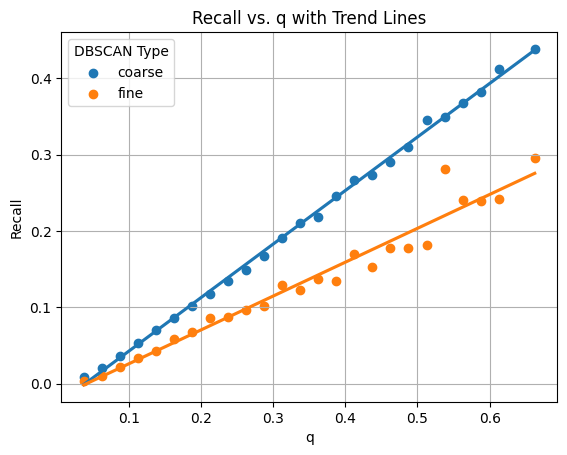

<Figure size 640x480 with 0 Axes>

In [33]:
for dbscan_type, group_data in averaged_df.groupby('dbscan'):
    plt.scatter(group_data['q_bin_med'], group_data['recall'], label=dbscan_type)
    
    # Trend line
    sns.regplot(
        x='q_bin_med', 
        y='recall', 
        data=group_data, 
        scatter=False, 
        ci=None
    )

# Add labels and legend
plt.xlabel("q")
plt.ylabel("Recall")
plt.title("Recall vs. q with Trend Lines")
plt.legend(title="DBSCAN Type")
plt.grid(True)
plt.show()

# Save the figure
plt.savefig("global.png")

## need to check everything below

## Bar charts from diaries, type vs fraction_time

In [16]:
output_type = []
output_size = []
output_truehome = []
for agent_id, agent in population_n.roster.items():
    d = agent.diary.dropna()
    d['id'] = agent_id
    d['type'] = d['location'].apply(lambda b: city.buildings[b].building_type)
    d['size'] = d['location'].apply(lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
    d['true_home'] = d.apply(lambda x: agent.home == x.location, axis=1)
    bin_edges = [0, 1, 4, 100]
    bin_labels = ['small', 'medium', 'large']
    d['size'] = pd.cut(d['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

    d_type_agg = d.groupby(['id', 'type'], observed=False).duration.sum().reset_index()
    d_size_agg = d.groupby(['id', 'size'], observed=False).duration.sum().reset_index()
    d_truehome_agg = d.groupby(['id', 'true_home'], observed=False).duration.sum().reset_index()
    output_type += [d_type_agg]
    output_size += [d_size_agg]
    output_truehome += [d_truehome_agg]

bars_type_gc = pd.concat(output_type)
temp = bars_type_gc.groupby('id')['duration'].transform('sum')
bars_type_gc['duration'] = bars_type_gc['duration'] / temp

bars_size_gc = pd.concat(output_size)
temp = bars_size_gc.groupby('id')['duration'].transform('sum')
bars_size_gc['duration'] = bars_size_gc['duration'] / temp

bars_trhome_gc = pd.concat(output_truehome)
temp = bars_trhome_gc.groupby('id')['duration'].transform('sum')
bars_trhome_gc['duration'] = bars_trhome_gc['duration'] / temp

all_stop_tables['type'] = all_stop_tables['location'].apply(
    lambda b: city.buildings[b].building_type if b in city.buildings else None)

all_stop_tables['true_home'] = all_stop_tables.apply(
    lambda x: population_n.roster[x.id].home == x.location, axis=1)

all_stop_tables['size'] = all_stop_tables['location'].apply(
    lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
bin_edges = [0, 1, 4, 100]
bin_labels = ['small', 'medium', 'large']
all_stop_tables['size'] = pd.cut(all_stop_tables['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

bars_type = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'type'], observed=False).duration.sum().reset_index()
temp = bars_type.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_type['duration'] = bars_type['duration'] / temp

bars_size = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'size'], observed=False).duration.sum().reset_index()
temp = bars_size.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_size['duration'] = bars_size['duration'] / temp

bars_trhome = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'true_home'], observed=False).duration.sum().reset_index()
temp = bars_trhome.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_trhome['duration'] = bars_trhome['duration'] / temp

# Ensure all combinations of 'id', 'dbscan', 'sparsity', and 'type' are present
unique_ids = bars_type['id'].unique()
unique_dbscan = bars_type['dbscan'].unique()
unique_sparsity = bars_type['sparsity'].unique()
unique_types = bars_type['type'].unique()
all_combinations = pd.DataFrame(list(product(unique_ids, unique_dbscan, unique_sparsity, unique_types)),
                                columns=['id', 'dbscan', 'sparsity', 'type'])
bars_type = all_combinations.merge(bars_type, on=['id', 'dbscan', 'sparsity', 'type'], how='left')
bars_type['duration'] = bars_type['duration'].fillna(0)

bars_rog = all_stop_tables.groupby(['id', 'dbscan', 'sparsity']).agg(
    rog_d=('rog_d', 'mean'),
    rog_sd=('rog_sd', 'mean')
).reset_index()

[Text(0.2, 0, 'Low Sparsity'), Text(1.2, 0, 'High Sparsity')]

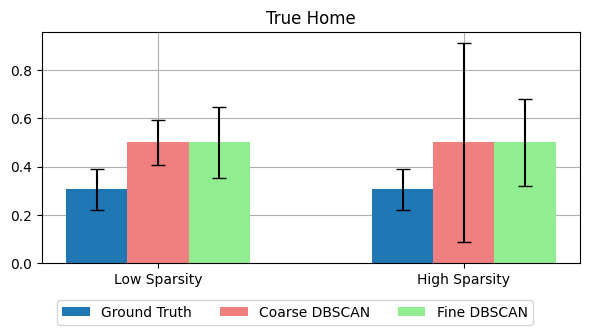

In [17]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

grouped_gc = bars_trhome_gc.groupby('true_home')['duration']
mean_duration_gc = grouped_gc.mean()[True]
std_duration_gc = grouped_gc.std()[True]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_duration_gc, bar_width, yerr=std_duration_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_trhome[bars_trhome['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
    std_duration = df_sparsity.groupby('sparsity')['duration'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('True Home')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

[Text(0.2, 0, 'Low Sparsity'), Text(1.2, 0, 'High Sparsity')]

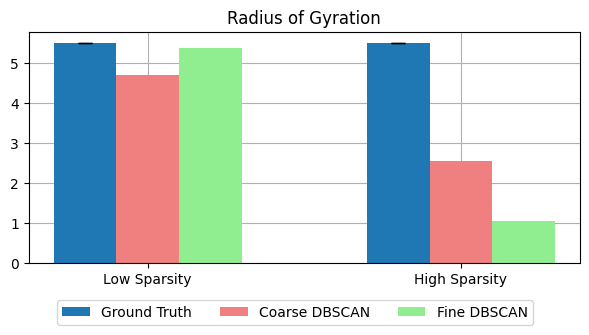

In [18]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

mean_gc = bars_rog['rog_d'].mean()
std_gc = bars_rog['rog_d'].std()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_rog[bars_rog['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['rog_sd'].mean()
    std_duration = df_sparsity.groupby('sparsity')['rog_sd'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('Radius of Gyration')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

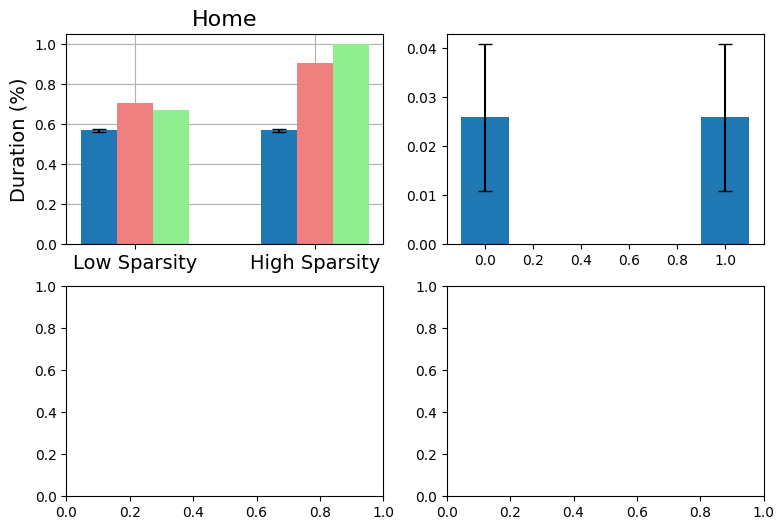

In [19]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_types = bars_type_gc['type'].unique()

grouped_gc = bars_type_gc.groupby('type')['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_type in enumerate(building_types):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_type]
    std_gc = std_duration_gc[building_type]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_type[bars_type['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['type'] == building_type]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_type.capitalize()}', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=14)

plt.savefig('bar_charts.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_sizes = bars_size_gc['size'].unique()

grouped_gc = bars_size_gc.groupby('size', observed=False)['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_size in enumerate(building_sizes):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_size]
    std_gc = std_duration_gc[building_size]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_size[bars_size['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['size'] == building_size]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_size.capitalize()} Buildings', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig('bar_size.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Curves

### Fix frequency (q). Vary sparsity pattern by changing first two params.

In [ ]:
%%time

def process_seed(seed, nhpp_params, dbscan_params, lachesis_params, city):
    results_dbscan = []
    results_lachesis = []
    
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    start_time=datetime(2024, 1, 1, hour=0, minute=0))

    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, T=datetime(2024, 1, 15, hour=0, minute=0), seed=seed)

    for nhpp_param in nhpp_params: 
        Bethany.sample_traj_hier_nhpp(*nhpp_param, seed=seed)
        qstat = q_stat(Bethany)

        for k in range(len(dbscan_params)):
            dbscan_param = dbscan_params[k]
            lachesis_param = lachesis_params[k]

            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            lachesis_out = sd.lachesis_patches(Bethany.sparse_traj, *lachesis_param)

            stop_table_dbscan = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)
            stop_table_lachesis = sd.generate_stop_table(Bethany.sparse_traj, lachesis_out)

            result_dbscan = {
                'seed': seed,
                'alg_param': ['coarse', 'fine'][k],
                'beta_dur': nhpp_param[1],
                'q': qstat,
                'recall': 0,
                'precision': 0,
                'stop_merging': None,
                'trip_merging': None,
                'missed': 0,
                'split': None,
                'rog_diary': 0,
                'rog_alg': 0
            }

            result_lachesis = result_dbscan.copy()

            if stop_table_dbscan.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_dbscan.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_dbscan = identify_stop(dbscan_out, Bethany.sparse_traj, stop_table_dbscan)
                # stop_table_dbscan['location'] = stop_table_dbscan.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_dbscan, Bethany)
                result_dbscan.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

            if stop_table_lachesis.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_lachesis.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_lachesis = identify_stop(lachesis_out, Bethany.sparse_traj, stop_table_lachesis)
                # stop_table_lachesis['location'] = stop_table_lachesis.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_lachesis, Bethany)
                result_lachesis.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

                results_dbscan.append(result_dbscan)
                results_lachesis.append(result_lachesis)

    return pd.DataFrame(results_dbscan), pd.DataFrame(results_lachesis)


seeds = range(1, 175)
dbscan_params = [(360, 5, 2), (60, 1.5, 3)]
lachesis_params = [(10, 480, 6), (10, 60, 1.5)]
beta_starts = range(120, 1600, 40)
beta_durs = range(30, 400, 10)
beta_ping = 10

nhpp_params = [(start, dur, beta_ping) for start, dur in zip(beta_starts, beta_durs)]

with ProcessPoolExecutor() as executor:
    work = partial(process_seed, nhpp_params=nhpp_params,
                   dbscan_params=dbscan_params, lachesis_params=lachesis_params,
                   city=city)
    all_results = list(executor.map(work, seeds))

results_dbscan = [result[0] for result in all_results]
results_lachesis = [result[1] for result in all_results]

results_dbscan = pd.concat(results_dbscan, ignore_index=True)
results_lachesis = pd.concat(results_lachesis, ignore_index=True)

results_dbscan.to_pickle('results-sparsity-dbscan-nofilter-1.pkl')
results_lachesis.to_pickle('results-sparsity-lachesis-nofilter-1.pkl')

In [ ]:
import pickle

with open('results-sparsity-dbscan-nofilter.pkl', 'rb') as file:
    results_dbscan = pickle.load(file)

with open('results-sparsity-lachesis-nofilter.pkl', 'rb') as file:
    results_lachesis = pickle.load(file)

In [ ]:
# Create bins for q, size 0.05 from 0 to 1
# bins = np.arange(0, 1.05, 0.05)
# labels = [i/100+0.025 for i in range(0, 100, 5)]
# results_dbscan['q_bin'] = pd.cut(results_dbscan['q'], bins=bins, labels=labels, include_lowest=True)
# results_lachesis['q_bin'] = pd.cut(results_lachesis['q'], bins=bins, labels=labels, include_lowest=True)

results_dbscan_sparsity = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_dbscan_sparsity = results_dbscan_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_dbscan_sparsity = results_dbscan_sparsity[results_dbscan_sparsity['count'] >= 10]

results_lachesis_sparsity = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_lachesis_sparsity = results_lachesis_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_lachesis_sparsity = results_lachesis_sparsity[results_lachesis_sparsity['count'] >= 10]

In [ ]:
results_dbscan_sparsity
#results_lachesis_sparsity

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 1.5))

for i, p in enumerate([2,4,5]):
    ax = axes[i]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_dbscan_sparsity[results_dbscan_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, p+4],
                label=['Coarse', 'Fine'][j],
                color=['red', 'darkgreen'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Stop Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.55))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-dbscan.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i in range(6):
    ax = axes[i % 2, i//2]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_lachesis_sparsity[results_lachesis_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, i+4],
                label=['Coarse', 'Fine'][j],
                color=['black', 'red'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.15))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-lachesis.png")
plt.show()

### Fix sparsity. Vary DBSCAN parameters.

In [ ]:
seeds = range(100, 150)
hier_nhpp_params = [(90, 30, 4), (60, 60, 2)]  # 3pph, 12pph

# dbscan_params = (time_thresh, dist_thresh, min_pts)
dist_threshs = np.arange(5/15, 200/15, 0.25)

results = np.zeros((len(seeds), len(hier_nhpp_params), len(dist_threshs), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, hier_nhpp_param in enumerate(hier_nhpp_params):
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        truepph = round(len(Bethany.sparse_traj) * 2 / 9) / 2
        print(truepph)

        for k, dist_thresh in enumerate(dist_threshs):
            dbscan_param = (240, dist_thresh, 2)
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = dist_thresh
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Trip Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = q_stat(Bethany)  # q
                continue

            stop_table['location'] = stop_table.apply(
                lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = dist_thresh
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            #results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 3] = metrics['Stops Merged']
            results[i, j, k, 4] = metrics['Trip Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_param = np.nanmean(results, axis=0)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_param[j, :, :],
            columns=['dist_thresh', 'recall', 'precision', 'weighted_stop_merging', 'trip_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['dist_thresh'], results_df.iloc[:, i+1],
                label=['3pph', '12pph'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. DBSCAN parameters', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_params.png")
plt.show()